<a href="https://colab.research.google.com/github/nicha1997/Data-Analytics-for-Business/blob/main/XGBoost_Model_for_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib scikit-learn xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

# Load the dataset
df = pd.read_csv('Sandy-cleaned_sales_data.csv')

# Display the first few rows of the dataset
print(df.info())

# Feature Engineering and data cleansing

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract useful features from the date
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week

# Create lag features (sales from the previous day and previous week)
for i in range(1, 8, 1):
  df[f'lag_{i}'] = df.groupby(['store', 'item'])['sales'].shift(i)

# Create rolling average features (7-day and 30-day rolling average)
df['rolling_7'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7).mean())
df['rolling_14'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=14).mean())
df['rolling_30'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30).mean())
df['rolling_std_7'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7).std())
df['rolling_std_14'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=14).std())
df['rolling_std_30'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30).std())

# Drop rows with NaN values that result from shift and rolling operations
df.dropna(inplace=True)

# Display the first few rows after adding features
print(df.head())
print(df.columns.to_list())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   913000 non-null  object 
 1   store                  913000 non-null  int64  
 2   item                   913000 non-null  int64  
 3   sales                  913000 non-null  int64  
 4   year                   913000 non-null  int64  
 5   month                  913000 non-null  int64  
 6   day                    913000 non-null  int64  
 7   month_year             913000 non-null  object 
 8   day_of_week            913000 non-null  int64  
 9   day_month_combination  913000 non-null  object 
 10  cumulative_sales       913000 non-null  int64  
 11  rolling_sales          912994 non-null  float64
 12  lagged_sales           912999 non-null  float64
 13  store_item             913000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
m

In [ ]:
# Select features for the model
features = ['store'
            , 'item'
            , 'month'
            , 'day'
            , 'year'
            , 'day_of_week'
            , 'week_of_year'
            , 'lag_1'
            , 'lag_2'
            , 'lag_3'
            , 'lag_4'
            , 'lag_5'
            , 'lag_6'
            , 'lag_7'
            , 'rolling_7'
            , 'rolling_14'
            , 'rolling_30'
            , 'rolling_std_7'
            , 'rolling_std_14'
            , 'rolling_std_30']
X = df[features].copy()
y = df['sales'].copy()

# Split the dataset into training and testing sets using 2017 as test
filter = df['date'].dt.year == 2017
X_train = X[~filter]
X_test = X[filter]
y_train = y[~filter]
y_test = y[filter]

# Display the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Features", X.columns.to_list())

X_train shape: (716000, 20)
X_test shape: (182500, 20)
Features ['store', 'item', 'month', 'day', 'year', 'day_of_week', 'week_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_7', 'rolling_14', 'rolling_30', 'rolling_std_7', 'rolling_std_14', 'rolling_std_30']


In [ ]:
from sklearn.model_selection import GridSearchCV

# Taking too much time
# Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror') # Define the model before using it in GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9]
}

# Set up GridSearchCV with XGBoost
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}


Train RMSE: 2.6213338785934934
Train R-squared: 0.9911488890647888
Test RMSE: 3.8023951666394242
Test R-squared: 0.9854773879051208


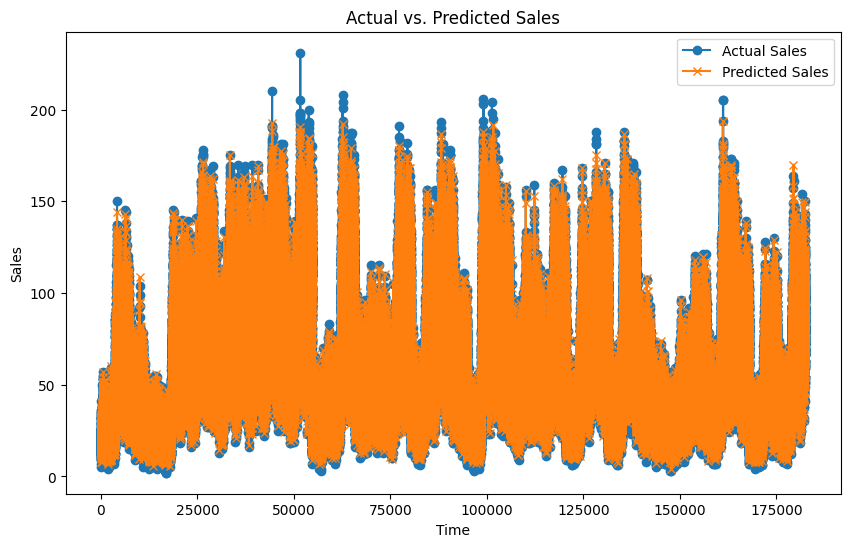

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Create an XGBoost regressor instance
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective for XGBoost
    n_estimators=150,              # Number of trees
    learning_rate=0.1,             # Step size
    max_depth=10,                  # Maximum depth of trees
    subsample=0.8,                 # Percentage of samples used per tree
    colsample_bytree=0.9           # Percentage of features used per tree
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
# Train-set
y_pred_train = model.predict(X_train)

# Calculate RMSE (Root Mean Squared Error) - Train-set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Train RMSE:", rmse_train)

# Calculate R-squared - Train-set
r2_train = r2_score(y_train, y_pred_train)
print("Train R-squared:", r2_train)

# Make predictions
# Test-set
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error) - Test-set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse_test)

# Calculate R-squared - Test-set
r2_test = r2_score(y_test, y_pred)
print("Test R-squared:", r2_test)

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', marker='o')
plt.plot(y_pred, label='Predicted Sales', marker='x')
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

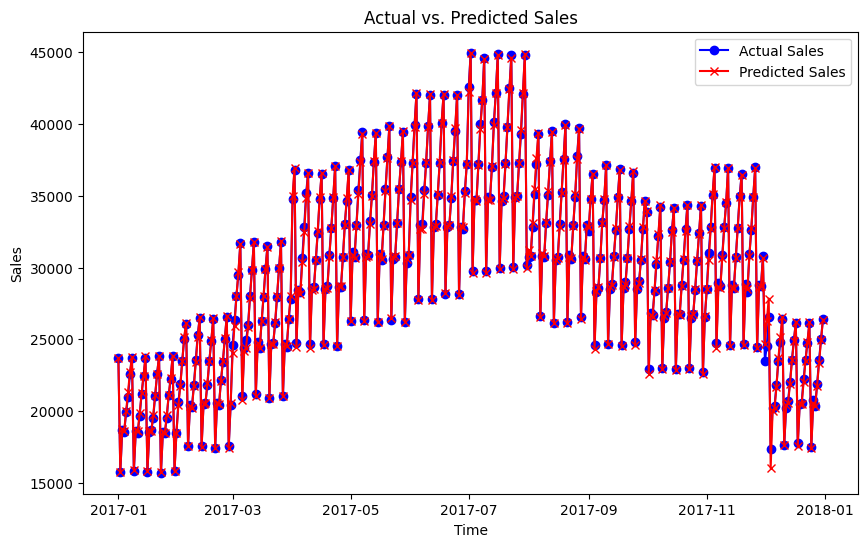

In [ ]:
# Plot the actual vs. predicted values
test_plot_df = pd.DataFrame(y_pred, columns=['pred_sales']).reset_index(drop=True)
pred_plot_df = pd.merge(y_test, df[df['date'].dt.year == 2017][['month_year', 'date', 'store', 'item']], left_index=True, right_index=True).reset_index(drop=True)
df_plot = pd.concat([test_plot_df, pred_plot_df], axis=1)
df_plot_agg = df_plot.groupby('date', as_index=False)[['sales', 'pred_sales']].sum()
plt.figure(figsize=(10, 6))
plt.plot(df_plot_agg['date'], df_plot_agg['sales'], label='Actual Sales', color='blue', marker='o')
plt.plot(df_plot_agg['date'], df_plot_agg['pred_sales'], label='Predicted Sales', color='red',marker='x')
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Production Model
# Predict all item and store sales in the next 365 days

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

# Define the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective for XGBoost
    n_estimators=150,              # Number of trees
    learning_rate=0.1,             # Step size
    max_depth=10,                   # Maximum depth of trees
    subsample=0.8,                 # Percentage of samples used per tree
    colsample_bytree=0.9          # Percentage of features used per tree
)

# Train the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

# Prepare a DataFrame to hold all predictions
all_predictions = []

# Prepare loop count
n_loop = df[['store', 'item']].drop_duplicates().shape[0]
c = 0

# Iterate over each unique store and item
for store in df['store'].unique():

    for item in df['item'].unique():

        c += 1

        if c % 20 == 0:
            print(f'Predicting store: {store}, item: {item}\nProgress: {c/n_loop:.1%}')

        # Filter data for the current store and item
        filtered_df = df[(df['store'] == store) & (df['item'] == item)]

        # Generate future dates for predictions
        last_date = filtered_df['date'].max()
        future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 366)] # Predict next 365 days sales

        # Create a DataFrame for future predictions
        future_df = pd.DataFrame({'date': future_dates})

        future_df['month'] = future_df['date'].dt.month
        future_df['year'] = future_df['date'].dt.year
        future_df['day'] = future_df['date'].dt.day
        future_df['day_of_week'] = future_df['date'].dt.dayofweek
        future_df['week_of_year'] = future_df['date'].dt.isocalendar().week
        future_df['store'] = store
        future_df['item'] = item

        # Initialize features in future_df
        for lag in range(1, 8):
            future_df[f'lag_{lag}'] = np.nan
        future_df['rolling_7'] = np.nan
        future_df['rolling_std_7'] = np.nan
        future_df['rolling_14'] = np.nan
        future_df['rolling_std_14'] = np.nan
        future_df['rolling_30'] = np.nan
        future_df['rolling_std_30'] = np.nan

        # Iterate to predict future sales
        predictions = []
        for i in range(len(future_df)):
            # For the first day, use lagged values and rolling features from historical data
            if i == 0:
                # Use last known sales from the filtered data
                last_sales = filtered_df['sales'].iloc[-1] if not filtered_df.empty else 0
                # Populate lag features from historical data
                for lag in range(1, 8):
                    if len(filtered_df) >= lag:
                        future_df.loc[i, f'lag_{lag}'] = filtered_df['sales'].iloc[-lag]
                # Populate rolling features
                if len(filtered_df) >= 7:
                    future_df.loc[i, 'rolling_7'] = filtered_df['sales'].iloc[-7:].mean()
                    future_df.loc[i, 'rolling_std_7'] = filtered_df['sales'].iloc[-7:].std()
                if len(filtered_df) >= 14:
                    future_df.loc[i, 'rolling_14'] = filtered_df['sales'].iloc[-14:].mean()
                    future_df.loc[i, 'rolling_std_14'] = filtered_df['sales'].iloc[-14:].std()
                if len(filtered_df) >= 30:
                    future_df.loc[i, 'rolling_30'] = filtered_df['sales'].iloc[-30:].mean()
                    future_df.loc[i, 'rolling_std_30'] = filtered_df['sales'].iloc[-30:].std()
            else:

                # For subsequent predictions, use the previous prediction
                last_sales = predictions[-1]
                for lag in range(1, 8):
                    future_df.loc[i, f'lag_{lag}'] = predictions[i - lag] if i >= lag else filtered_df['sales'].iloc[i-lag]

                # Calculate rolling features using available predictions or fallback to historical data
                rolling_start_index = max(0, i - 6)
                future_df.loc[i, 'rolling_7'] = np.mean(predictions[rolling_start_index:i]) if len(predictions) >= 7 else np.mean(filtered_df['sales'].iloc[-7+i:].to_list() + predictions[0:i]) if len(filtered_df) >= 7 else np.nan
                future_df.loc[i, 'rolling_std_7'] = np.std(predictions[rolling_start_index:i]) if len(predictions) >= 7 else np.std(filtered_df['sales'].iloc[-7+i:].to_list() + predictions[0:i]) if len(filtered_df) >= 7 else np.nan

                rolling_start_index = max(0, i - 13)
                future_df.loc[i, 'rolling_14'] = np.mean(predictions[rolling_start_index:i]) if len(predictions) >= 14 else np.mean(filtered_df['sales'].iloc[-14+i:].to_list() + predictions[0:i]) if len(filtered_df) >= 14 else np.nan
                future_df.loc[i, 'rolling_std_14'] = np.std(predictions[rolling_start_index:i]) if len(predictions) >= 14 else np.std(filtered_df['sales'].iloc[-14+i:].to_list() + predictions[0:i]) if len(filtered_df) >= 14 else np.nan

                rolling_start_index = max(0, i - 29)
                future_df.loc[i, 'rolling_30'] = np.mean(predictions[rolling_start_index:i]) if len(predictions) >= 30 else np.mean(filtered_df['sales'].iloc[-30+i:].to_list() + predictions[0:i]) if len(filtered_df) >= 30 else np.nan
                future_df.loc[i, 'rolling_std_30'] = np.std(predictions[rolling_start_index:i]) if len(predictions) >= 30 else np.std(filtered_df['sales'].iloc[-30+i:].to_list() + predictions[0:i]) if len(filtered_df) >= 30 else np.nan

            # Prepare features for prediction
            X_future = future_df[features].iloc[i:i + 1]
            predicted_sales = model.predict(X_future)[0]
            predictions.append(predicted_sales)

        # Add predictions to future_df
        future_df['predicted_sales'] = predictions

        # Append the results for this store and item
        all_predictions.append(future_df[['date', 'store', 'item', 'predicted_sales']])

# Combine all predictions into a single DataFrame
final_predictions = pd.concat(all_predictions)

# Save the predictions to a CSV file
final_predictions.to_csv('predicted_sales.csv', index=False)

print("Predictions saved to 'predicted_sales.csv'")

RMSE: 2.7686812450610727
Predicting store: 1, item: 20
Progress: 4.0%
Predicting store: 1, item: 40
Progress: 8.0%
Predicting store: 2, item: 10
Progress: 12.0%
Predicting store: 2, item: 30
Progress: 16.0%
Predicting store: 2, item: 50
Progress: 20.0%
Predicting store: 3, item: 20
Progress: 24.0%
Predicting store: 3, item: 40
Progress: 28.0%
Predicting store: 4, item: 10
Progress: 32.0%
Predicting store: 4, item: 30
Progress: 36.0%
Predicting store: 4, item: 50
Progress: 40.0%
Predicting store: 5, item: 20
Progress: 44.0%
Predicting store: 5, item: 40
Progress: 48.0%
Predicting store: 6, item: 10
Progress: 52.0%
Predicting store: 6, item: 30
Progress: 56.0%
Predicting store: 6, item: 50
Progress: 60.0%
Predicting store: 7, item: 20
Progress: 64.0%
Predicting store: 7, item: 40
Progress: 68.0%
Predicting store: 8, item: 10
Progress: 72.0%
Predicting store: 8, item: 30
Progress: 76.0%
Predicting store: 8, item: 50
Progress: 80.0%
Predicting store: 9, item: 20
Progress: 84.0%
Predicting 

In [ ]:
final_predictions[['store', 'item']].drop_duplicates().groupby('store')['item'].count()

,item
store,
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


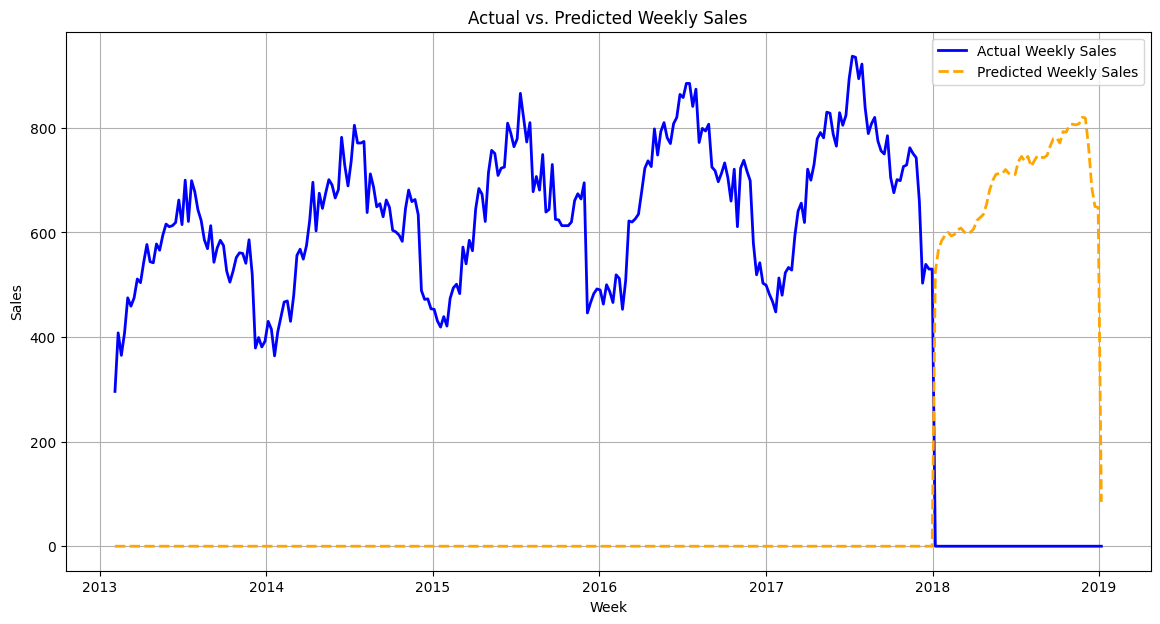

In [ ]:
# Combine actual and predicted sales for plotting
filter_str = 'store == 10 and item == 25'
df_combined = pd.concat([df.query(filter_str)[['date', 'sales']], final_predictions.query(filter_str)[['date', 'predicted_sales']]], axis=0)
df_combined.set_index('date', inplace=True)

# Resample the data to weekly sales
weekly_sales = df_combined.resample('W').sum()

# Plot the weekly sales
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales.index, weekly_sales['sales'], label='Actual Weekly Sales', color='blue', linewidth=2)
plt.plot(weekly_sales.index, weekly_sales['predicted_sales'], label='Predicted Weekly Sales', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Playground

In [ ]:
df_agg = df_combined.copy().reset_index()
df_agg['month'] = df_agg['date'].dt.month
df_agg['year'] = df_agg['date'].dt.year
df_agg.query('date >= "2016-01-01"').groupby(['year', 'month'])[['sales', 'predicted_sales']].sum()

sales  predicted_sales
year month                        
2016 1      449.0         0.000000
     2      450.0         0.000000
     3      589.0         0.000000
     4      694.0         0.000000
     5      782.0         0.000000
     6      790.0         0.000000
     7      903.0         0.000000
     8      727.0         0.000000
     9      709.0         0.000000
     10     699.0         0.000000
     11     662.0         0.000000
     12     496.0         0.000000
2017 1      485.0         0.000000
     2      487.0         0.000000
     3      561.0         0.000000
     4      677.0         0.000000
     5      773.0         0.000000
     6      850.0         0.000000
     7      873.0         0.000000
     8      794.0         0.000000
     9      736.0         0.000000
     10     660.0         0.000000
     11     668.0         0.000000
     12     533.0         0.000000
2018 1        0.0       888.492065
     2        0.0       843.285278
     3        0.0       936.782654

In [ ]:
# Production Model
# Predict 1 item, 1 store

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

# Load the dataset
df = pd.read_csv('train.csv')

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract useful features from the date column
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# Create lag features
df['lag_1'] = df['sales'].shift(1)
df['lag_7'] = df['sales'].shift(7)

# Create rolling average features
df['rolling_7'] = df['sales'].rolling(window=7).mean()
df['rolling_30'] = df['sales'].rolling(window=30).mean()

# Drop rows with NaN values
df.dropna(inplace=True)

# Select features for the model
features = ['store', 'item', 'month', 'day_of_week', 'lag_1', 'lag_7', 'rolling_7', 'rolling_30']
X = df[features]
y = df['sales']

# Define the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective for XGBoost
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Step size
    max_depth=7,                   # Maximum depth of trees
    subsample=0.8,                 # Percentage of samples used per tree
    colsample_bytree=1           # Percentage of features used per tree
)

# Train the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y, y_pred)
print("MAPE:", mape)

# Generate future dates
last_date = df['date'].max()
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 91)]  # Next 90 days

# Init prediction df list
future_df_list = list()

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'date': future_dates})

# Extract features for future dates
future_df['month'] = future_df['date'].dt.month
future_df['day_of_week'] = future_df['date'].dt.dayofweek
future_df['store'] = df['store'].mode()[0]  # Assuming the most common store (modify as needed)
future_df['item'] = df['item'].mode()[0]    # Assuming the most common item (modify as needed)

# Initialize lag and rolling features
future_df['lag_1'] = np.nan
future_df['lag_7'] = np.nan
future_df['rolling_7'] = np.nan
future_df['rolling_30'] = np.nan

# Iterate to predict future sales
predictions = []
for i in range(len(future_df)):
    if i == 0:
        # For the first future date, use the last known sales
        last_sales = df['sales'].iloc[-1]
    else:
        # Use the last predicted sales
        last_sales = predictions[-1] if predictions else df['sales'].iloc[-1]

    # Set lag features
    future_df.loc[i, 'lag_1'] = last_sales
    if i >= 7:
        future_df.loc[i, 'lag_7'] = predictions[i-7]  # Lag of 7 days

    # Calculate rolling averages if enough predictions have been made
    if i >= 6:
        future_df.loc[i, 'rolling_7'] = np.mean(predictions[i-6:i+1])
    if i >= 29:
        future_df.loc[i, 'rolling_30'] = np.mean(predictions[i-29:i+1])

    # Prepare the features for prediction
    X_future = future_df[features].iloc[i:i+1]

    # Predict sales
    predicted_sales = model.predict(X_future)[0]
    predictions.append(predicted_sales)

# Add predictions to future_df
future_df['predicted_sales'] = predictions

# Display predictions for the next 3 months
print(future_df[['date', 'predicted_sales']].head(90))  # Displaying predictions for next 90 days
